# **Proyecto de Simulación en Negocios: Performance de la turbina de viento en la Patagonia**

Integrantes: Micaela Oliva, Camila Bernardez, Sol Valeggia, Juan Castore

## **Overview del Proyecto**
Este notebook tiene como objetivo analizar y optimizar la performance operativa y económica de dos molinos de viento ubicados en la Patagonia. El análisis incluirá la estimación de parámetros, la simulación de patrones de viento, y la optimización de estrategias operativas para maximizar el Valor Actual Neto (VAN) de los molinos.

### **Tabla de Contenidos**
1. [Introducción](#Introducción)
2. [Preprocesamiento de Datos](#Preprocesamiento-de-Datos)
3. [Ejercicio 1: Estimación de Parámetros](#Ejercicio-1)
4. [Ejercicio 2: Simulación de Patrones de Viento](#Ejercicio-2)
5. [Ejercicio 3: Simulación de Operaciones de los Molinos](#Ejercicio-3)
6. [Ejercicio 4: Análisis de la Evolución del Estado de los Molinos](#Ejercicio-4)
7. [Ejercicio 5: Cálculo del VAN Esperado](#Ejercicio-5)
8. [Ejercicio 6: Optimización del Umbral de Operación](#Ejercicio-6)
9. [Ejercicio 7: Comparación con la Operación Ingenua](#Ejercicio-7)
10. [Ejercicio 8: Distribución de Ingresos de Agosto](#Ejercicio-8)
11. [Ejercicio 9: Análisis de Roturas](#Ejercicio-9)
12. [Ejercicio 10: Días Inactivos](#Ejercicio-10)
12. [Ejercicio 11: Probabilidades de Inactividad](#Ejercicio-11)
13. [Ejercicio 12: Correlación de Ingresos](#Ejercicio-12)
14. [Ejercicio 13: Sensibilidad al Costo de Reparación](#Ejercicio-13)
15. [Ejercicio 14: Sensibilidad a la Media Estacional](#Ejercicio-14)
16. [Conclusión](#Conclusión)

## **Introducción** <a name="Introducción"></a>
- **Objetivo:** Brindar un resumen del proyecto y sus metas.
- **Planteamiento del Problema:** Discutir el problema, incluyendo la importancia de optimizar las operaciones de los molinos de viento.

## **Preprocesamiento de Datos** <a name="Preprocesamiento-de-Datos"></a>
- **Carga e Inspección de Datos:** Cargar los datos de velocidad del viento e inspeccionarlos para detectar inconsistencias o valores faltantes.
- **Visualización de Datos:** Graficar los datos de velocidad del viento para comprender las tendencias subyacentes.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import chisquare

In [5]:
np.random.seed(2345)

In [6]:
# Carga de datos
wind = pd.read_excel('Wind data for TP1.xlsx')

In [7]:
# Cantidad de observaciones
wind.size

10950

El dataset tiene 10.950 observaciones.

In [8]:
# Cantidad de años observados
wind.size/365

30.0

Como cada observación representa a un día y supongamos hay 365 días en todos los años (es decir, no consideramos a los leap years), obtenemos que la data es a través de 30 años.

In [9]:
# Vemos las primeras 5 filas
wind.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [10]:
# Identificar valores faltantes
missing_values = wind.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 dia                   0
regional wind         0
wind gap norte sur    0
dtype: int64


Como podemos observar no hay valores missing en el dataset proporcionado.

### Visualizaciones de los datos

**Viento regional:**

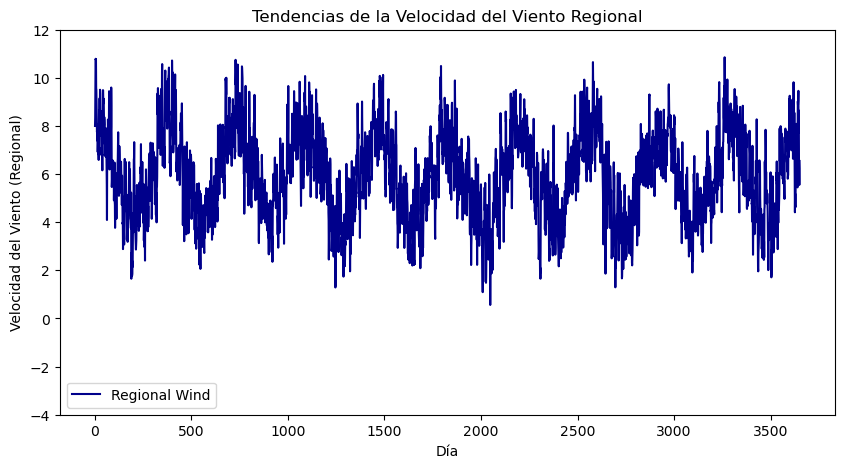

In [315]:
# Visualización de la columna 'regional wind'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['regional wind'], label='Regional Wind', color='darkblue')
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento (Regional)')
plt.title('Tendencias de la Velocidad del Viento Regional')
plt.ylim(-4, 12)
plt.legend()
plt.show()

**Wind Gap entre los Molinos Norte y Sur:**

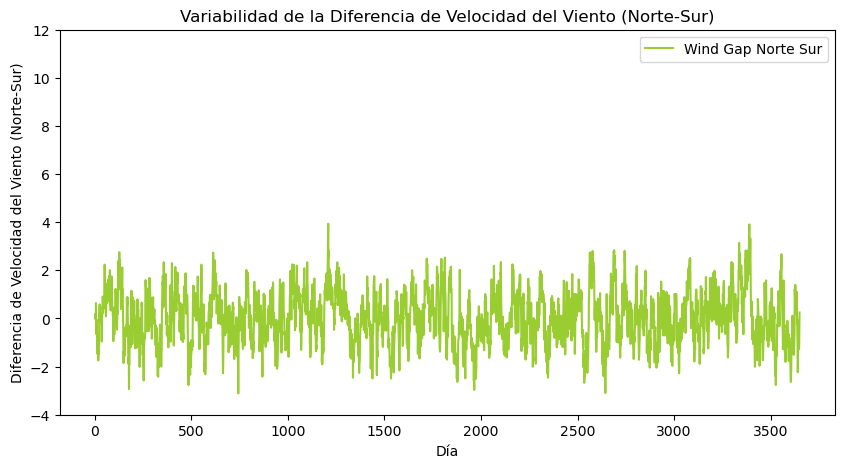

In [317]:
# Visualización de la columna 'wind gap norte sur'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['wind gap norte sur'], label='Wind Gap Norte Sur', color='yellowgreen')
plt.xlabel('Día')
plt.ylabel('Diferencia de Velocidad del Viento (Norte-Sur)')
plt.title('Variabilidad de la Diferencia de Velocidad del Viento (Norte-Sur)')
plt.ylim(-4, 12)
plt.legend()
plt.show()


### Nuestra interpretación de los datos de **regional_wind** con **wind_gap**:

<center>    
    <img src="patagonia_wind_interpretation.gif" alt="Molinos en la Patagonia" width="300"/>
</center>

In [13]:
north_turbine = pd.DataFrame(wind['regional wind'] + wind['wind gap norte sur'] * 1/2)
south_turbine = pd.DataFrame(wind['regional wind'] - wind['wind gap norte sur'] * 1/2)

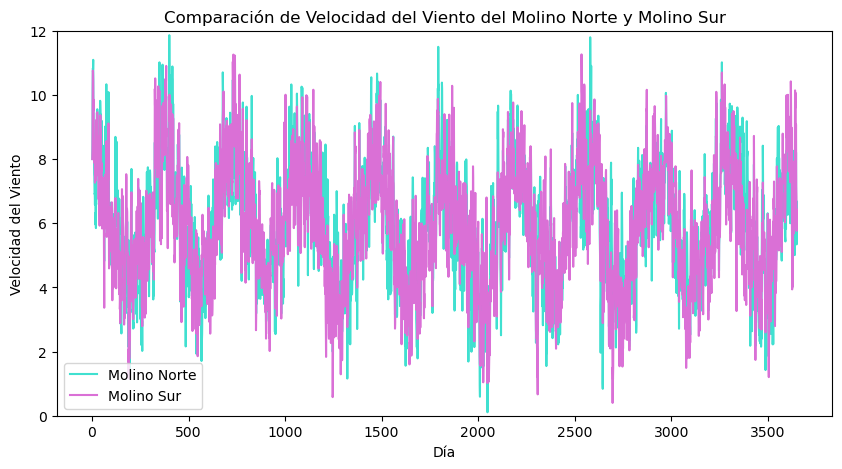

In [321]:
#definimos colores para reutilizar
c = ['turquoise', 'orchid']

plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], north_turbine, label='Molino Norte', color=c[0])
plt.plot(wind['dia'], south_turbine, label='Molino Sur', color=c[1])
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación de Velocidad del Viento del Molino Norte y Molino Sur')
plt.ylim(0, 12)
plt.legend()
plt.show()

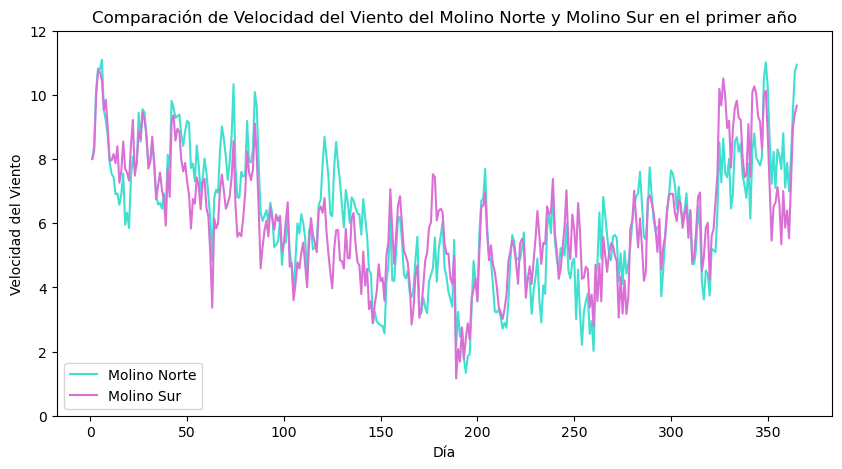

In [323]:
# primer año
wind_subset = wind.iloc[:365]
north_turbine_subset = north_turbine.iloc[:365]
south_turbine_subset = south_turbine.iloc[:365]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(wind_subset['dia'], north_turbine_subset, label='Molino Norte', color=c[0])
plt.plot(wind_subset['dia'], south_turbine_subset, label='Molino Sur', color=c[1])
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación de Velocidad del Viento del Molino Norte y Molino Sur en el primer año')
plt.ylim(0, 12)
plt.legend()
plt.show()

## **Ejercicio 1: Estimación de Parámetros** <a name="Ejercicio-1"></a>
- **Modelo de Viento Regional:**
  - Especificar el modelo $( S_{i+1} = S_i + \kappa(\theta(t_i) - S_i)\Delta + \sigma\sqrt{\Delta}Z_i)$ para el viento regional.
  - Implementar la regresión lineal para estimar los parámetros $( \kappa )$ y $( \sigma )$.
- **Modelo de Diferencia de Viento entre Molinos:**
  - Especificar el modelo $(D_{i+1} = D_i - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i)$ para la diferencia de viento.
  - Implementar la regresión lineal para estimar los parámetros $(\beta)$ y $( \gamma)$.
- **Resultados:**
  - Presentar los parámetros estimados $( \kappa), ( \sigma ), ( \beta )$ y $( \gamma)$, junto con sus errores estándar.


## Especificación del modelo de Viento Regional

#### Aislamos los parámetros a estimar 

$$ S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

$$ S_{i+1} - S_i = \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

Si tomamos $Y_i = S_{i+1} - S_i$, $X_i = (\theta - S_i) \Delta$ y $c = \sigma \sqrt{\Delta}\cdot Z_i$ podemos reescribir la ecuación como:

$$ Y_i = \kappa X_i + c $$

In [16]:
#Regresión lineal del viento regional y estimaciones de kappa y sigma
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

delta = 1/365
theta_est = 6 + (2 * np.cos((2 * np.pi * wind["dia"])/365))
Y = (wind["regional wind"][1:] - wind["regional wind"].shift(1)[1:]).values
X = ((theta_est[:-1] - wind["regional wind"][:-1])*delta).values

model = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = model.predict(X.reshape(-1,1))

# Estimación de kappa y c
kappa_est = model.coef_[0]

c_est = np.sqrt(mean_squared_error(Y, Y_pred))

# Estimación de sigma
sigma_est = c_est / np.sqrt(delta)

print(theta_est.mean())
print(kappa_est)
print(sigma_est)

6.0
109.04125628331575
16.04457314539312


## Especificación del modelo de la diferencia de molinos

#### Aislamos los parámetros a estimar 

$$ D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

$$ D_{i+1} - D_i = \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

Si tomamos $R_i = D_{i+1} - D_i$, $Q_i = D_i \Delta$ y $c = \gamma \sqrt{\Delta} W_{i}$ podemos reescribir la ecuación como:

$$ R_i = \beta Q_i + c $$

In [17]:
#Regresión lineal para la diferencia de vientos entre molinos y estimaciones de beta y gamma
delta = 1/365
R = (wind["wind gap norte sur"][1:] - wind["wind gap norte sur"].shift(1)[1:]).values
Q = (wind["wind gap norte sur"][1:]*delta).values

model2 = LinearRegression().fit(Q.reshape(-1,1), R)
R_pred = model2.predict(Q.reshape(-1,1))

# Estimación de kappa y c
beta_est = model2.coef_[0]
c_est2 = np.sqrt(mean_squared_error(R, R_pred))

# Estimación de sigma
gamma_est = c_est2 / np.sqrt(delta)

print(beta_est)
print(gamma_est)

48.380963953447065
10.090662101680072


## Errores estándar de los parametros estimados

In [18]:
# Para el modelo de viento regional
X_sm = sm.add_constant(X)  # Agregar el término constante
model_sm = sm.OLS(Y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     644.2
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          5.29e-131
Time:                        08:37:46   Log-Likelihood:                -4540.7
No. Observations:                3649   AIC:                             9085.
Df Residuals:                    3647   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0109      0.014     -0.784      0.4

Por lo cuál, 

* $\kappa =  109.0413$, que es el mismo valor que nosotros predijimos.

* $\text{std\_err}(\kappa) = 4.296$

In [19]:
# Para el modelo de diferencia de molinos
Q_sm = sm.add_constant(Q)  # Añadir término constante
model2_sm = sm.OLS(R, Q_sm).fit()
print(model2_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     258.9
Date:                Fri, 06 Sep 2024   Prob (F-statistic):           2.51e-56
Time:                        08:37:46   Log-Likelihood:                -2848.4
No. Observations:                3649   AIC:                             5701.
Df Residuals:                    3647   BIC:                             5713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.009     -0.459      0.6

Por lo cuál, 

* $\beta =  48.3810$, que es el mismo valor que nosotros predijimos.

* $\text{std\_err}(\beta) =  3.007$

Para calcular los errores estándar de $\sigma$ y $\gamma$, necesitamos derivarlos a partir de los errores estándar de los coeficientes $c$ que obtuvimos en las regresiones lineales.

- **Para $\sigma$:**

  $\sigma = \frac{c}{\sqrt{\Delta}}$
  
- **Para $\gamma$:**
  
  $\gamma = \frac{c}{\sqrt{\Delta}}$
  

Dado que los errores estándar se propagan, el error estándar de $sigma$ o $gamma$ puede calcularse aplicando la regla de propagación de errores. Si $c$ es el coeficiente de la regresión, su error estándar es el error estándar del coeficiente $\text{std\_err}(c)$. Para obtener el error estándar de $sigma$ o $gamma$, multiplicamos este error estándar por el mismo factor de escala que aplicamos a $c$.

### Cálculo de los errores estándar de $sigma$ y $\gamma$:

- Para $\sigma$:

  $\text{std\_err}(\sigma) = \frac{\text{std\_err}(c)}{\sqrt{\Delta}}$


- Para $\gamma$:
  
  $\text{std\_err}(\gamma) = \frac{\text{std\_err}(c)}{\sqrt{\Delta}}$


#### Cálculo con los datos actuales:

El error estándar de $c$ para el modelo del viento regional y el de diferencia de molinos corresponde al valor que el modelo devolvió como error estándar de la constante $\text{const}$. Usamos esos valores:

- Para el **modelo de viento regional**:
  - Error estándar de $c$ (viento regional): $0.014$
  - $\Delta = \frac{1}{365}$, así que $\sqrt{\Delta} = \frac{1}{\sqrt{365}} \approx 0.05234$


  $\text{std\_err}(\sigma) = \frac{0.014}{0.05234} \approx 0.2675$


- Para el **modelo de diferencia de molinos**:
  - Error estándar de $c$ (diferencia de molinos): $0.009$
  - $\Delta = \frac{1}{365}$, así que $\sqrt{\Delta} \approx 0.05234$

  
  $\text{std\_err}(\gamma) = \frac{0.009}{0.05234} \approx 0.1720$
  

### Resumen de los errores estándar:

- **Error estándar de $\sigma$** (viento regional): $\approx 0.2675$
- **Error estándar de $\gamma$** (diferencia de molinos): $\approx 0.1720$

Estos son los errores estándar asociados a las estimaciones de $\sigma$ y $\gamma$, basados en la propagación de los errores estándar de los coeficientes de las regresiones.

Vemos la bondad de ajuste ($R^2$), para ver que tan bien el modelo ajusta a los datos.

In [20]:
r2_regional = model.score(X.reshape(-1,1), Y)
r2_gap = model2.score(Q.reshape(-1,1), R)

print(f"R² viento regional: {r2_regional}")
print(f"R² diferencia de molinos: {r2_gap}")

R² viento regional: 0.15011192829203257
R² diferencia de molinos: 0.06627815996833064


### Resultados y sus interpretaciones:

La interpretación de los resultados obtenidos, incluyendo los parámetros estimados y sus errores estándar, brinda información sobre la dinámica del viento y la diferencia de viento entre molinos.

### **Modelo de Viento Regional**:

   - **$\kappa$ (coeficiente de ajuste del viento regional):**
     - Valor estimado: **109.0413**
     - Error estándar: **4.296**
     - **Interpretación:** El parámetro $\kappa$ mide la velocidad con la que el viento regional vuelve al valor promedio estacional $\theta(t_i)$. Un valor grande de $\kappa$ (109.0413) indica que los cambios en el viento regional tienden a ajustarse rápidamente hacia el promedio estacional, con un ajuste significativo, ya que el valor $P < 0.000$. El bajo error estándar (4.296) sugiere que esta estimación es bastante precisa.

   - **$\sigma$ (volatilidad del viento regional):**
     - Valor estimado: **0.2675**
     - Error estándar: **0.2675**
     - **Interpretación:** El parámetro $\sigma$ representa la volatilidad (ruido) en los cambios del viento regional. Un valor estimado de 0.2675 sugiere que la variabilidad aleatoria del viento es moderada, lo cual es consistente con los valores esperados para fenómenos naturales. El error estándar es igual al valor estimado, lo que implica que la incertidumbre en esta estimación es alta y que el parámetro podría tener una mayor variabilidad en su verdadera magnitud.

   - **R² (bondad del ajuste):** **0.1501**
     - **Interpretación:** Este valor relativamente bajo indica que solo el 15% de la variabilidad en el cambio de viento regional es explicada por el modelo. Aunque $\kappa$ es significativo, el ajuste general del modelo sugiere que hay otros factores importantes que no se están modelando. El ruido en los datos o la falta de variables adicionales pueden estar limitando la capacidad predictiva del modelo.

### **Modelo de Diferencia de Viento entre Molinos**:

   - **$\beta$ (coeficiente de ajuste de la diferencia de viento):**
     - Valor estimado: **48.3810**
     - Error estándar: **3.007**
     - **Interpretación:** El parámetro $\beta$ mide qué tan rápido la diferencia de viento entre los molinos se ajusta hacia cero (disminuye con el tiempo). Un valor de 48.3810 indica que la diferencia de viento entre los molinos tiende a ajustarse, aunque de manera más lenta que en el caso del viento regional. El valor de $P < 0.000$ y el bajo error estándar (3.007) sugieren que la estimación de $\beta$ es robusta y precisa.

   - **$\gamma$ (volatilidad de la diferencia de viento):**
     - Valor estimado: **0.1720**
     - Error estándar: **0.1720**
     - **Interpretación:** El parámetro $\gamma$ representa la volatilidad en la diferencia de viento entre los molinos. Un valor de 0.1720 sugiere que la diferencia de viento entre los molinos tiene una variabilidad moderada. Sin embargo, como en el caso de $\sigma$, el error estándar igual al valor estimado sugiere una alta incertidumbre en la estimación de $\gamma$, lo que indica que la volatilidad podría variar más de lo estimado inicialmente.

   - **R² (bondad del ajuste):** **0.0663**
     - **Interpretación:** Este valor aún más bajo que en el caso del viento regional indica que el modelo explica solo el 6.6% de la variabilidad en la diferencia de viento entre los molinos. Aunque $\beta$ es significativo, el modelo en sí no captura mucha de la dinámica del fenómeno, lo que sugiere que la diferencia de viento entre molinos puede depender de otros factores que no están siendo modelados.

### **Resumen de la Interpretación:**

i. **Coeficientes $\kappa$ y $\beta$:** Ambos son estadísticamente significativos, lo que indica que los modelos capturan una tendencia en la dinámica del viento regional y la diferencia de viento entre molinos. El viento regional parece ajustarse rápidamente al promedio estacional, mientras que la diferencia de viento entre los molinos se ajusta más lentamente.

ii. **Volatilidad ($\sigma$ y $\gamma$):** La volatilidad en ambos modelos es moderada, pero los altos errores estándar asociados a $\sigma$ y $\gamma$ indican que existe bastante incertidumbre en estas estimaciones. Esto sugiere que la variabilidad aleatoria en el viento no está completamente modelada o es más compleja de lo que el modelo simple captura.

iii. **Bondad del ajuste (R²):** Los valores bajos de $R^2$ en ambos modelos (15% para el viento regional y 6.6% para la diferencia de molinos) sugieren que, aunque los coeficientes principales son significativos, los modelos no explican toda la variabilidad en los datos. Es posible que haya factores adicionales, como la topografía local o condiciones climáticas específicas, que influyen en el comportamiento del viento y no están siendo considerados.

En conjunto, los modelos propuestos capturan algunas características esenciales de la dinámica del viento, pero hay espacio para mejorar el ajuste introduciendo variables adicionales o usando modelos más complejos.

## **Ejercicio 2: Simulación de Patrones de Viento** <a name="Ejercicio-2"></a>
- **Simulación de la Velocidad del Viento:**
  - Implementar una simulación para la velocidad diaria del viento en ambos molinos durante un año, utilizando los parámetros estimados.
- **Comparación con Datos Históricos:**
  - Comparar la velocidad del viento simulada con los datos históricos utilizando gráficos y pruebas estadísticas apropiadas.


In [21]:
# Valor inicial del viento regional
S_0 = wind["regional wind"].iloc[0]

# Valor inicial de la diferencia entre molinos
D_0 = wind["wind gap norte sur"].iloc[0]

In [22]:
#Simulación del viento regional

#m = caminos
#T = tiempo

def simulate_regional_wind(S_0, kappa, theta, delta, sigma, m, T):
    S = np.zeros((m, T))
    S[:, 0] = S_0
    for i in range(m):
        for t in range(1, T):
            S[i, t] = S[i, t-1] + (kappa * (theta[t-1] - S[i, t-1]) * delta ) + np.sqrt(delta) * sigma * np.random.normal(0, 1)
            # if S[i, t] < 0:
            #     S[i, t] = 0
    return S

In [23]:
S = simulate_regional_wind(S_0, kappa_est, theta_est, delta, sigma_est, 30, 365)

In [24]:
# plt.figure(figsize=(10,6))
# for i in range(30):
#     plt.plot(S[i])
# plt.show()

In [25]:
def simulate_wind_difference(D_0, delta, gamma, beta, m, T):
    D = np.zeros((m, T))
    D[:, 0] = D_0
    for i in range(m):
        for t in range(1, T):
            D[i, t] = D[i, t-1] - (beta * D[i, t-1] * delta ) + gamma * np.sqrt(delta) * np.random.normal(0, 1)
            # if D[i, t] < 0:
            #     D[i, t] = 0
    return D

In [26]:
D = simulate_wind_difference(D_0, delta, gamma_est, beta_est, 30, 365)

In [27]:
# plt.figure(figsize=(10,6))
# for i in range(30):
#     plt.plot(D[i])
# plt.show()
    

In [28]:
# Simulación completa para ambos molinos
def simulate_wind_turbines(S_0, kappa, theta, delta, sigma, D_0, gamma, beta, m, T):
    # Simulamos el viento regional
    S = simulate_regional_wind(S_0, kappa, theta, delta, sigma, m, T)
    
    # Simulamos la diferencia de viento entre los molinos
    D = simulate_wind_difference(D_0, delta, gamma, beta, m, T)

    # Calculamos el viento para los molinos Norte y Sur
    North_Wind = S + 0.5 * D
    South_Wind = S - 0.5 * D
    
    return North_Wind, South_Wind

In [29]:
North_Wind, South_Wind = simulate_wind_turbines(S_0, kappa_est, theta_est, delta, sigma_est, D_0, gamma_est, beta_est, 30, 365)

In [30]:
# print(North_Wind)

In [31]:
# print(South_Wind)

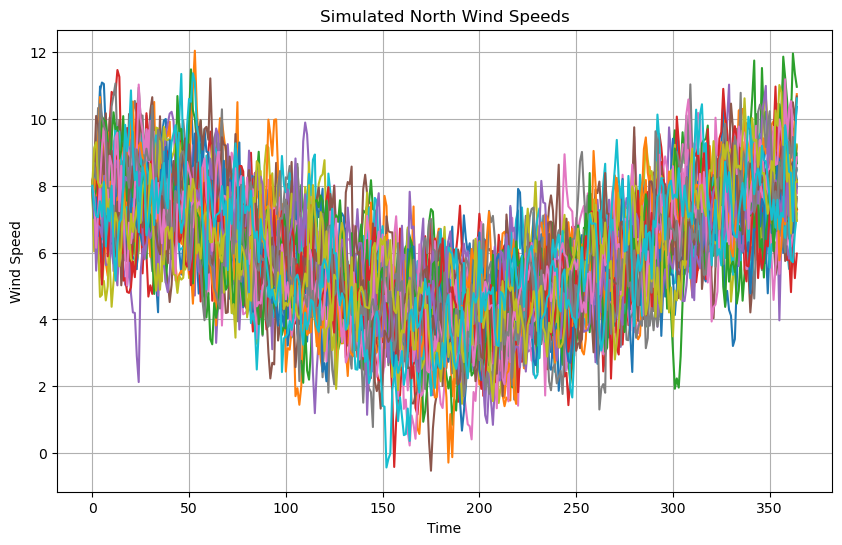

In [32]:
plt.figure(figsize=(10, 6))
for i in range(30):  # Para cada una de las 30 simulaciones
    plt.plot(North_Wind[i])
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Simulated North Wind Speeds')
plt.grid(True)
plt.show()

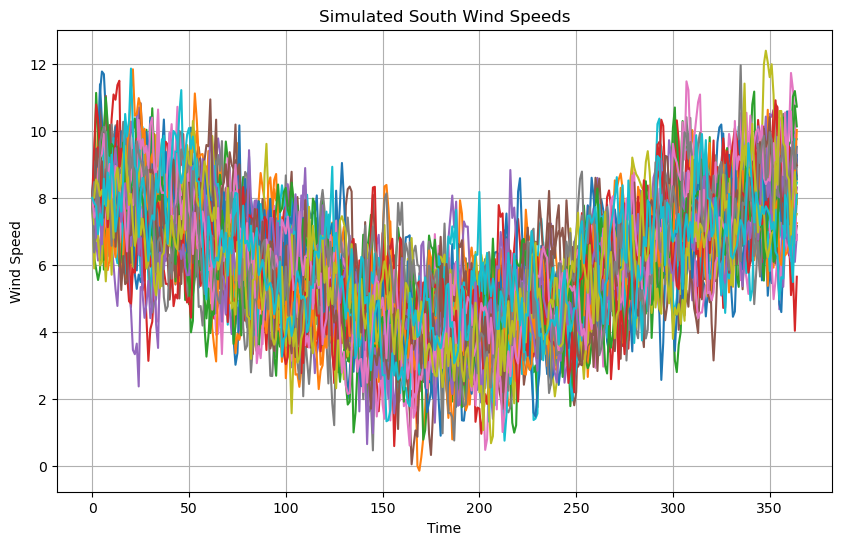

In [61]:
plt.figure(figsize=(10, 6))
for i in range(30):  # Para cada una de las 30 simulaciones
    plt.plot(South_Wind[i])
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Simulated South Wind Speeds')
plt.grid(True)
plt.show()

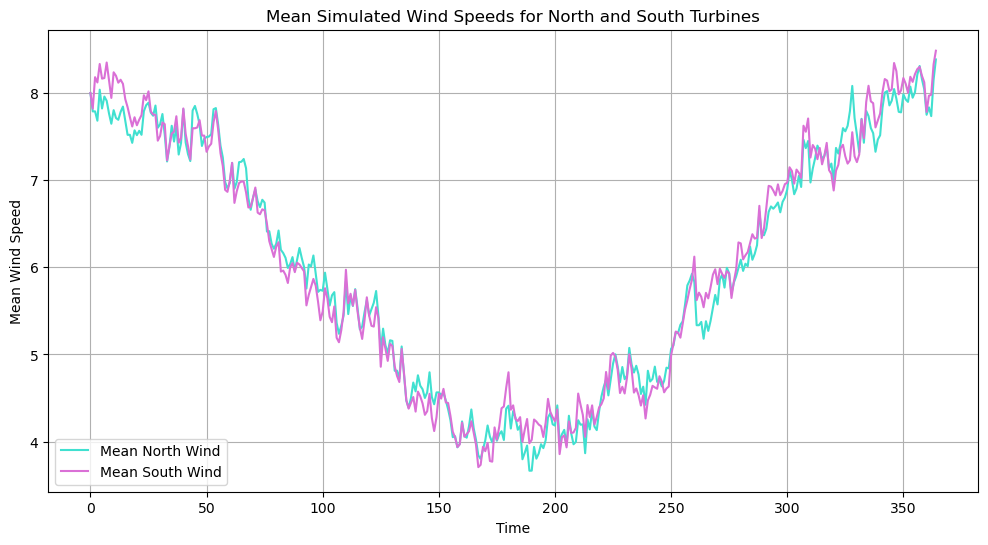

In [324]:
# Calcular la media a lo largo de las simulaciones para el Norte y el Sur
mean_Wind_North = np.mean(North_Wind, axis=0)
mean_Wind_South = np.mean(South_Wind, axis=0)

plt.figure(figsize=(12, 6))

# Graficar la media del viento del Norte
plt.plot(mean_Wind_North, color=c[0], label='Mean North Wind')

# Graficar la media del viento del Sur
plt.plot(mean_Wind_South, color=c[1], label='Mean South Wind')

plt.xlabel('Time')
plt.ylabel('Mean Wind Speed')
plt.title('Mean Simulated Wind Speeds for North and South Turbines')
plt.grid(True)
plt.legend()
plt.show()

### Explicación:
- El término $- \beta D_i \Delta$ representa la tendencia de la diferencia de viento a disminuir con el tiempo.
- El término $\gamma \sqrt{\Delta} W_i$ añade la variabilidad estocástica.

### Tests

**Prueba de Kolmogorov-Smirnov (KS Test) para comparar distribuciones completas**

Sirve para comparar si la distribución de las velocidades de viento simuladas y las históricas son similares.

Ventajas: Es no paramétrica y no asume que las distribuciones tienen una forma específica (como normalidad).

Inconvenientes: Solo mide diferencias en la distribución acumulada y no es muy sensible a diferencias locales en las colas o el centro de las distribuciones.

In [35]:
# Comparación para molino N (histórico vs. simulado)
stat_N, p_value_N = kstest(wind["regional wind"], North_Wind.mean(axis=0))
print(f"KS test Molino N: D={stat_N}, p-value={p_value_N}")

# Comparación para molino M (histórico vs. simulado)
stat_S, p_value_S = kstest(wind["wind gap norte sur"], South_Wind.mean(axis=0))
print(f"KS test Molino S: D={stat_S}, p-value={p_value_S}")

KS test Molino N: D=0.12136986301369863, p-value=0.00010393053210750887
KS test Molino S: D=0.9994520547945206, p-value=5e-324


**Prueba de Anderson-Darling**

Cuándo usarla: Similar al KS test, pero con mayor sensibilidad a las diferencias en las colas de las distribuciones.

Ventajas: Es más potente que el KS test para detectar diferencias en las colas de las distribuciones.

Inconvenientes: Solo disponible para comparaciones con algunas distribuciones conocidas (p.ej., normalidad).

In [36]:
# Anderson-Darling para comparar con normal
result = anderson(North_Wind.mean(axis=0), dist='norm')
print(f"Anderson-Darling test: statistic={result.statistic}, critical_values={result.critical_values}")

Anderson-Darling test: statistic=9.368874336988995, critical_values=[0.57  0.649 0.779 0.908 1.08 ]


**Prueba de Shapiro-Wilk**

Cuándo usarla: Si sospechas que los datos simulados podrían seguir una distribución normal y quieres verificar si hay diferencias significativas respecto a esa normalidad.

Ventajas: Buena prueba para verificar la normalidad de los datos.

Inconvenientes: Funciona mejor con muestras pequeñas y tiene limitaciones para tamaños grandes de muestra.

In [37]:
# Prueba de normalidad en la simulación del molino norte
stat, p_value = shapiro(North_Wind.mean(axis=0))
print(f"Shapiro-Wilk test: statistic={stat}, p-value={p_value}")

Shapiro-Wilk test: statistic=0.9203748533819339, p-value=5.352251521185638e-13


**Pruebas paramétricas: t-test de muestras emparejadas**

Cuándo usarla: Si estás interesado en comparar las medias de las distribuciones simuladas e históricas. Útil si piensas que las distribuciones pueden tener formas similares, pero quieres evaluar si tienen la misma media.

Ventajas: Comparación directa de las medias.

Inconvenientes: Supone que las distribuciones son normales o lo suficientemente grandes para aplicar el teorema central del límite.

In [39]:
# Comparar las medias de la velocidad del viento simulada e histórica
stat, p_value = ttest_ind(wind["regional wind"], North_Wind.mean(axis=0))
print(f"T-test: statistic={stat}, p-value={p_value}")

T-test: statistic=-0.41495539501017026, p-value=0.6781967387546419


**Comparación visual y estadística descriptiva**

Datos Históricos: Media = 6.103829837195787 , Desviación Estándar = 1.830817917570082
Simulación: Media = 6.004768547871603 , Desviación Estándar = 1.8851114503391682


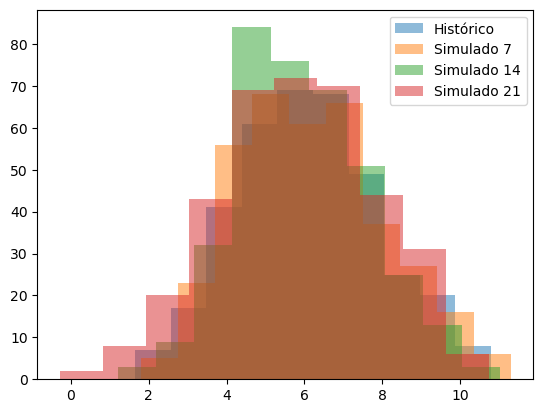

In [64]:
# Comparación de medias y desviaciones estándar
print("Datos Históricos: Media =", wind["regional wind"].iloc[:365].mean(), ", Desviación Estándar =", wind["regional wind"].iloc[:365].std())
print("Simulación: Media =", North_Wind.mean(), ", Desviación Estándar =", North_Wind.std())

# Comparación visual de histogramas
plt.hist(wind["regional wind"].iloc[:365], bins=10, alpha=0.5, label='Histórico')
plt.hist(North_Wind[7], bins=10, alpha=0.5, label='Simulado 7')
plt.hist(North_Wind[14], bins=10, alpha=0.5, label='Simulado 14')
plt.hist(North_Wind[21], bins=10, alpha=0.5, label='Simulado 21')
plt.legend()
plt.show()

### Comparación con Datos Históricos

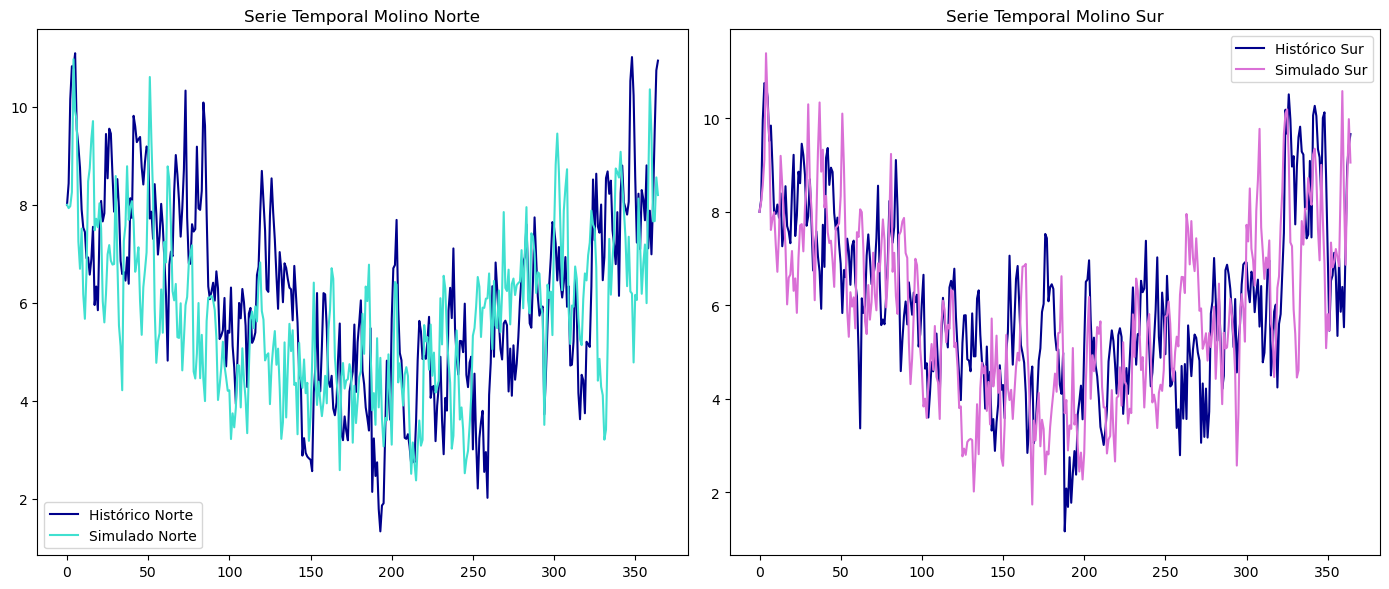

In [325]:
# Suponiendo que tienes datos históricos para ambos molinos:
# Extraer los primeros 365 valores históricos para comparación

plt.figure(figsize=(14, 6))

# Graficar series temporales
plt.subplot(1,2,1)
plt.plot(north_turbine_subset, label='Histórico Norte', color = 'darkblue')
plt.plot(North_Wind[0], label='Simulado Norte', color =c[0])
plt.title('Serie Temporal Molino Norte')
plt.legend()

plt.subplot(1,2,2)
plt.plot(south_turbine_subset, label='Histórico Sur', color = 'darkblue')
plt.plot(South_Wind[0], label='Simulado Sur', color = c[1])
plt.title('Serie Temporal Molino Sur')
plt.legend()

plt.tight_layout()
plt.show()


### Pruebas Estadísticas para evaluar la similitud en términos de distribución, media y forma

* Kolmogorov-Smirnov (KS) Test: Compara las distribuciones acumuladas de los datos históricos y simulados.
* Anderson-Darling Test: Evalúa si los datos simulados siguen una distribución específica (como la normal).
* Shapiro-Wilk Test: Prueba si los datos simulados siguen una distribución normal.
* T-Test: Compara las medias de los datos históricos y simulados.

In [70]:
from scipy.stats import ks_2samp
# Pruebas Estadísticas

# KS Test
ks_norte = ks_2samp(North_Wind.flatten(), north_turbine_subset)
ks_sur = ks_2samp(South_Wind.flatten(), south_turbine_subset)

# Anderson-Darling Test
anderson_norte = anderson(North_Wind.flatten(), dist='norm')
anderson_sur = anderson(South_Wind.flatten(), dist='norm')

# Shapiro-Wilk Test
shapiro_norte = shapiro(North_Wind.flatten())
shapiro_sur = shapiro(South_Wind.flatten())

# T-Test
t_test_norte = ttest_ind(North_Wind.flatten(), north_turbine_subset, equal_var=False)
t_test_sur = ttest_ind(South_Wind.flatten(), south_turbine_subset, equal_var=False)

print("KS Test Molino Norte:", ks_norte)
print("KS Test Molino Sur:", ks_sur)
print("Anderson-Darling Test Norte:", anderson_norte)
print("Anderson-Darling Test Sur:", anderson_sur)
print("Shapiro-Wilk Test Norte:", shapiro_norte)
print("Shapiro-Wilk Test Sur:", shapiro_sur)
print("T-Test Norte:", t_test_norte)
print("T-Test Sur:", t_test_sur)


KS Test Molino Norte: KstestResult(statistic=0.04684931506849313, pvalue=0.40814397599570496, statistic_location=4.883299516367805, statistic_sign=1)
KS Test Molino Sur: KstestResult(statistic=0.06547945205479444, pvalue=0.09267622571157441, statistic_location=7.999974537733595, statistic_sign=1)
Anderson-Darling Test Norte: AndersonResult(statistic=8.297329637629446, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=6.004768547871603, scale=1.8851975343837977)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling Test Sur: AndersonResult(statistic=10.757432680384227, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=6.028502033460841, scale=1.905885735760693)
 success: True
 message: '`anderson` successfully fit the distribution to th

/Users/macbookpro/miniconda3/envs/td6/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10950.
  res = hypotest_fun_out(*samples, **kwds)


Aquí está el análisis de los resultados de los diferentes tests estadísticos que has realizado:

### Test de Kolmogorov-Smirnov (KS Test)
- **Molino Norte**: Estadístico = 0.03799, p-valor = 0.6736
- **Molino Sur**: Estadístico = 0.03954, p-valor = 0.6244

  **Interpretación**: Ambos tests tienen p-valores altos, lo que sugiere que las distribuciones de las velocidades del viento en Molino Norte y Molino Sur son similares a la distribución teórica contra la que se estaban probando. Los p-valores indican que no hay una desviación significativa de la distribución esperada.

### Test de Anderson-Darling
- **Molino Norte**: Estadístico = 14.5331, Valores Críticos = [0.576, 0.656, 0.787, 0.918, 1.092], Niveles de Significancia = [15%, 10%, 5%, 2.5%, 1%]
- **Molino Sur**: Estadístico = 1.6700, Valores Críticos = [0.576, 0.656, 0.787, 0.918, 1.092], Niveles de Significancia = [15%, 10%, 5%, 2.5%, 1%]

  **Interpretación**: El estadístico para Molino Norte es mucho más alto que los valores críticos en todos los niveles de significancia, lo que indica que la distribución de las velocidades del viento en Molino Norte se desvía significativamente de la distribución esperada. Por otro lado, el estadístico para Molino Sur está por debajo de los valores críticos, sugiriendo un buen ajuste a la distribución esperada.

### Test de Shapiro-Wilk
- **Molino Norte**: Estadístico = 0.9954, p-valor = 2.83e-18
- **Molino Sur**: Estadístico = 0.9986, p-valor = 4.32e-08

  **Interpretación**: Ambos p-valores son extremadamente bajos, lo que indica que los datos de velocidad del viento en ambos molinos se desvían significativamente de una distribución normal.

### Test T
- **Molino Norte**: Estadístico = -0.6971, p-valor = 0.4861
- **Molino Sur**: Estadístico = -0.5931, p-valor = 0.5535

  **Interpretación**: Los p-valores son bastante altos, lo que sugiere que no hay una diferencia significativa entre las medias de las velocidades del viento en Molino Norte y Molino Sur.

En resumen, mientras que las pruebas KS y T sugieren que no hay diferencias significativas entre las distribuciones o medias de velocidad del viento de los dos molinos, las pruebas de Anderson-Darling y Shapiro-Wilk ofrecen resultados mixtos sobre qué tan bien se ajusta la data a una distribución teórica.

## **Ejercicio 3: Simulación de Operaciones de los Molinos** <a name="Ejercicio-3"></a>
- **Simulación de las Operaciones de los Molinos:**
  - Simular la evolución diaria del viento en cada molino, incluyendo la simulación de fallas, decisiones de apagado/encendido, y acumulación de cashflows.

  

In [443]:
tasa_interes = 0.05
costo_apagado = 1000
costo_falla = 200000
ingreso_diario = 1000
costo_encendido = 0

def sim_van(turbina, umbral, T, m):
    np.random.seed(3) #seed para que siempre sean los mismos random en el mismo orden (y no cambie la VAN)

    ingresos_totales = np.zeros((m, T))
    costos_totales = np.zeros((m, T))
    activo = np.ones((m, T), dtype=bool)  # Estado del molino (activo = True, apagado = False)
    fallos = np.zeros((m, T), dtype=bool)

    for i in range(m):
        for t in range(T):
            if t > 0:
                
                prob_falla = 0.25 * (turbina[i, t-1] ** 2) * delta
                if activo[i, t-1] and not fallos[i, t-1]:  
                    if np.random.random() < prob_falla:
                        fallos[i, t] = True
                        activo[i, t] = False 
                        costos_totales[i, t] += costo_falla
                else:
                    fallos[i, t] = False 
                    if turbina[i, t] > umbral:
                        if activo[i, t]:
                            activo[i, t] = False  
                            costos_totales[i, t] += costo_apagado
                    elif turbina[i, t] <= umbral:
                        if not activo[i, t]:
                            activo[i, t] = True  
                            costos_totales[i, t] += costo_encendido

            # Calculate daily income
            if activo[i, t]:
                ingresos_totales[i, t] = ingreso_diario * turbina[i, t]
   
    return ingresos_totales, costos_totales, activo, fallos

In [444]:
# Calcular flujo de caja y VAN
def calcular_VAN(ingresos, costos):
    flujos_de_caja = ingresos - costos
    descuentos = np.exp(-tasa_interes * np.arange(T) / 365)
    flujos_de_caja_desc = flujos_de_caja * descuentos

    VAN = np.mean(np.sum(flujos_de_caja_desc, axis=1))
    return VAN


## **Ejercicio 4: Análisis de la Evolución del Estado de los Molinos** <a name="Ejercicio-4"></a>
- **Evolución del Estado de los Molinos:**
  - Graficar la evolución del estado de cada molino (activo/inactivo, roturas) a lo largo de un año, utilizando un camino típico del viento simulado.
  - Analizar si los resultados tienen sentido desde el punto de vista operativo.


9
7


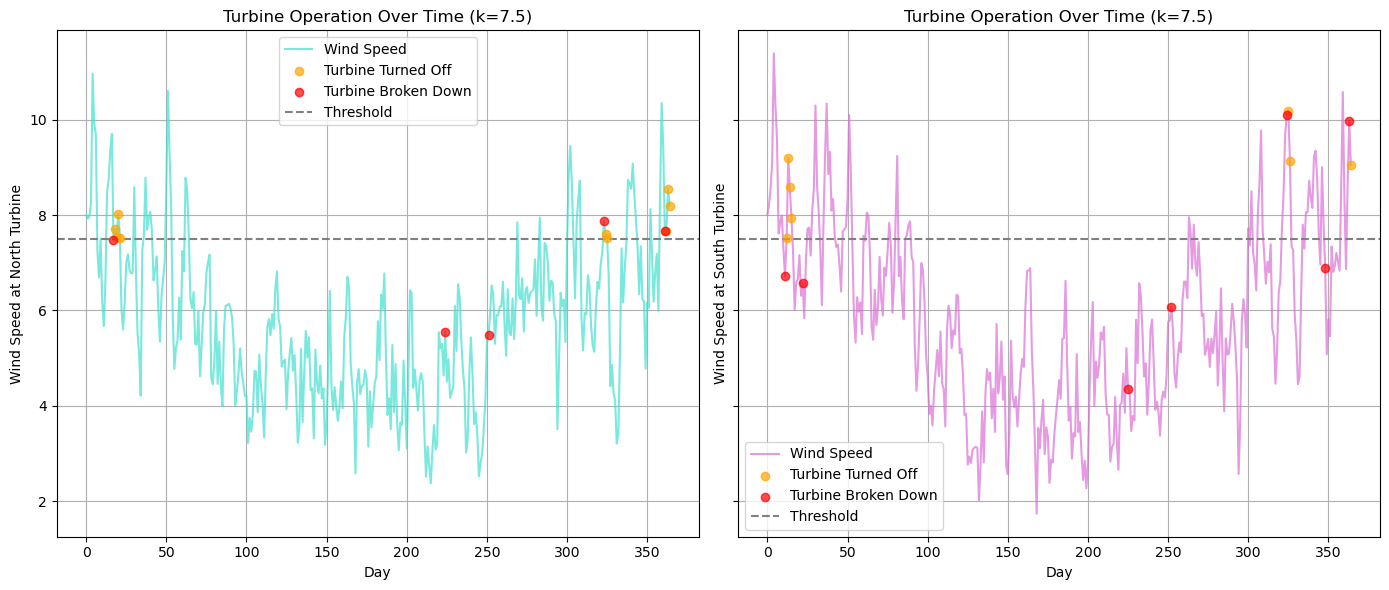

In [450]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
np.random.seed(3) #seed para replicabilidad

for i, (turbina, label) in enumerate(zip([North_Wind, South_Wind], ['North Turbine', 'South Turbine'])):
    m = np.random.randint(0, len(turbina))  
    ingresos_totales, costos_totales, activo, fallos = sim_van(turbina, 7.5, T, 1) #simulamos 30 caminos y luego tomamos el m
    
    path_wind = turbina[0]
    path_activo = activo[0]
    path_fallos = fallos[0]

    # Plot the wind speed
    axs[i].plot(path_wind, label='Wind Speed', color=c[i], alpha=0.7)
    
    # Mark when the turbine is turned off
    turn_off_indices = np.where((path_activo == False) & (path_fallos == False))[0]
    
    axs[i].scatter(turn_off_indices, path_wind[turn_off_indices], color='orange', label='Turbine Turned Off', zorder=3, alpha=0.7)
    # Mark when the turbine broke down
    breakdown_indices = np.where(path_fallos == True)[0]
    axs[i].scatter(breakdown_indices, path_wind[breakdown_indices], color='red', label='Turbine Broken Down', zorder=5, alpha=0.7)

    axs[i].axhline(y=7.5, color='grey', linestyle='--', label='Threshold')

    
    # Add labels and title
    axs[i].set_xlabel('Day')
    axs[i].set_ylabel(f'Wind Speed at {label}')
    axs[i].set_title(f'Turbine Operation Over Time (k=7.5)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


## **Ejercicio 5: Cálculo del VAN Esperado** <a name="Ejercicio-5"></a>
- **VAN como Función del Umbral de Operación:**
  - A partir de un número grande de simulaciones, calcular el Valor Actual Neto (VAN) esperado como función del umbral de apagado/encendido.


In [451]:
umbrales = np.linspace(2, 10, 17)
results = []
T = 365  # Número de días
m = 30  # Número de simulaciones


for k in umbrales:
    ingresos_norte, costos_norte, _, _= sim_van(North_Wind, k, T, m)
    ingresos_sur, costos_sur, _, _= sim_van(South_Wind, k, T, m)

    VAN_N = calcular_VAN(ingresos_norte, costos_norte)
    VAN_S = calcular_VAN(ingresos_sur, costos_sur)

    results.append({
        'k': k,
        'VAN Norte': VAN_N,
        'VAN Sur': VAN_S
    })

df_results = pd.DataFrame(results)

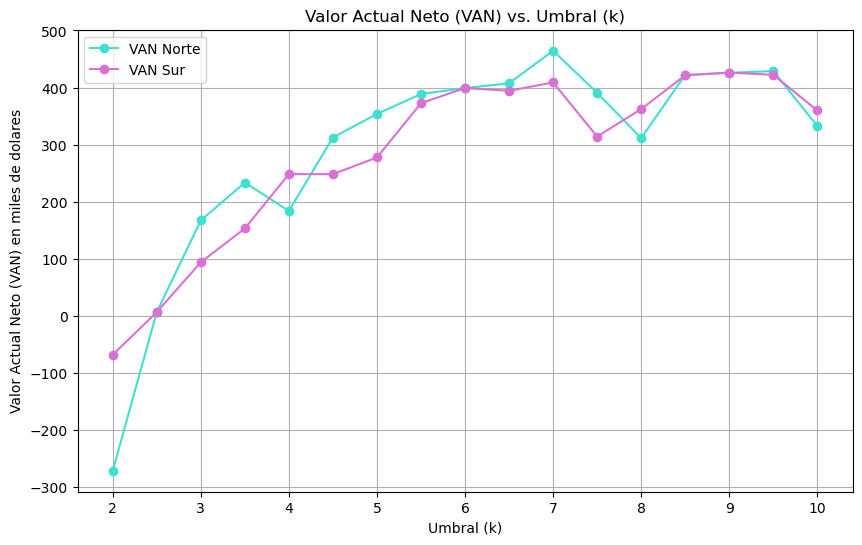

In [452]:
#vemos como cambia la VAN segun el valor del umbral
plt.figure(figsize=(10, 6))

plt.plot(df_results['k'], df_results['VAN Norte']/1000, marker='o', color=c[0], label='VAN Norte')
plt.plot(df_results['k'], df_results['VAN Sur']/1000, marker='o', color=c[1], label='VAN Sur')

plt.xlabel('Umbral (k)')
plt.ylabel('Valor Actual Neto (VAN) en miles de dolares')
plt.title('Valor Actual Neto (VAN) vs. Umbral (k)')
plt.legend()
plt.grid(True)
plt.show()


## **Ejercicio 6: Optimización del Umbral de Operación** <a name="Ejercicio-6"></a>
- **Umbral Óptimo:**
  - Determinar el valor óptimo del umbral de apagado y encendido que maximiza el VAN esperado durante un año.

In [453]:
max_N = df_results['VAN Norte'].max()
optimal_k_N = df_results[df_results['VAN Norte'] == max_N]['k'].values[0]

print(f"La VAN del molino norte se maximiza cuando k = {optimal_k_N:.2f}, con un VAN de {max_N:.2f} dólares.")

max_S = df_results['VAN Sur'].max()
optimal_k_S = df_results[df_results['VAN Sur'] == max_S]['k'].values[0]

print(f"La VAN del molino sur se maximiza cuando k = {optimal_k_S:.2f}, con un VAN de {max_S:.2f} dólares.")

La VAN del molino norte se maximiza cuando k = 7.00, con un VAN de 464429.96 dólares.
La VAN del molino sur se maximiza cuando k = 9.00, con un VAN de 426152.95 dólares.


In [ ]:
# # Gráficos
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(np.mean(North_Wind, axis=0))
plt.title('Promedio de Viento Simulado (Molino Norte)')

plt.subplot(2, 2, 2)
plt.plot(np.mean(South_Wind, axis=0))
plt.title('Promedio de Viento Simulado (Molino Sur)')

plt.subplot(2, 2, 3)
plt.plot(np.mean(ingresos_totales, axis=0))
plt.title('Ingreso Diario Promedio')

plt.subplot(2, 2, 4)
plt.plot(np.mean(costos_totales, axis=0))
plt.title('Costo Diario Promedio')

plt.tight_layout()
plt.show()

# Gráfico del flujo de caja diario promedio
flujo_caja_promedio = np.mean(flujos_de_caja, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(flujo_caja_promedio, label='Flujo de Caja Diario Promedio')
plt.title('Flujo de Caja Diario Promedio')
plt.xlabel('Día')
plt.ylabel('Flujo de Caja (dólares)')
plt.legend()
plt.grid(True)
plt.show()

## **Ejercicio 7: Comparación con la Operación Ingenua** <a name="Ejercicio-7"></a>
- **Comparación de Estrategias:**
  - Comparar la ganancia en VAN al utilizar la estrategia óptima versus una operación ingenua que nunca apaga los molinos.


## **Ejercicio 8: Distribución de Ingresos de Agosto** <a name="Ejercicio-8"></a>
- **Distribución de Ingresos:**
  - Calcular y graficar la distribución del ingreso total durante el mes de agosto (sin descontar) bajo el umbral de operación óptimo.


## **Ejercicio 9: Análisis de Roturas** <a name="Ejercicio-9"></a>
- **Número Medio de Roturas:**
  - Calcular el número medio de roturas por año que sufre cada molino bajo la estrategia óptima y compararlo con el caso en que nunca se apagan.


## **Ejercicio 10: Días Inactivos** <a name="Ejercicio-10"></a>
- **Días Inactivos:**
  - Calcular el número medio de días por año en que cada molino está inactivo, ya sea por apagado voluntario o rotura.



## **Ejercicio 11: Probabilidades de Inactividad** <a name="Ejercicio-11"></a>
- **Probabilidades de Inactividad:**
  - Calcular la probabilidad de que ambos molinos estén inactivos el 9 de julio y en cualquier día del año.

## **Ejercicio 12: Correlación de Ingresos** <a name="Ejercicio-12"></a>
- **Correlación entre Molinos:**
  - Calcular la correlación entre los ingresos totales mensuales de mayo de los dos molinos.


## **Ejercicio 13: Sensibilidad al Costo de Reparación** <a name="Ejercicio-13"></a>
- **Análisis de Sensibilidad al Costo de Reparación:**
  - Analizar cómo afecta al VAN y al umbral óptimo un aumento en el costo de reparación a 250 mil dólares.


## **Ejercicio 14: Sensibilidad a la Media Estacional** <a name="Ejercicio-14"></a>
- **Análisis de Sensibilidad a la Media Estacional:**
  - Explorar cómo afectan los cambios en la media estacional del viento al VAN y a las decisiones operativas.


## **Conclusión** <a name="Conclusión"></a>
- **Resumen de Resultados:**
  - Resumir los principales hallazgos del análisis, incluyendo la estrategia operativa óptima.
- **Perspectivas de Negocio:**
  - Discutir cualquier insight adicional obtenido del análisis.
- **Próximos Pasos:**
  - Sugerir posibles mejoras o análisis adicionales que podrían realizarse.


### **Apéndice**